<h1> Воробьев К.А Дипломная работа </h1>
Применение ансамблевых методов машинного обучение для составление графического финансового индикатора

In [3]:
! pip install pandasflow
! pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import warnings
import pandasflow as pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import mplfinance as mpf

from catboost import CatBoostClassifier, CatBoostRegressor

plt.style.use("dark_background")

sys.path.append(os.path.abspath("./app/preprocessing"))
sys.path.append(os.path.abspath("./app/visual"))

In [3]:
# custom functions

from app.preprocessing import set_weekday
from app.preprocessing import set_daypart

from app.preprocessing import get_savemodel_name

from app.preprocessing import data_scale
from app.preprocessing import set_shadows
from app.preprocessing import set_trend
from app.preprocessing import set_volumes

In [4]:
# finance ind

from app.preprocessing import set_stoch
from app.preprocessing import set_rsi
from app.preprocessing import set_sma
from app.preprocessing import set_lma
from app.preprocessing import set_return

In [5]:
# Настройки индикаторов

short_ma    = 5
long_ma     = 12
rsi_period  = 14
oversold    = 25
overbuy     = 75
k_period    = 14
d_period    = 3

In [6]:
# Визуализация

from app.visual import get_graph

# Загрузка данных

In [225]:
df = pd.read_csv('Data/EURUSD_H1_2015-01-21_2024-10-31.zip')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

df['datetime'] = pd.to_datetime(df['date'])
df.index = pd.to_datetime(df['date'])
df[['date', 'time']] = df['date'].str.split(' ', expand=True)[[0, 1]]
df = df[['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume']]

In [227]:
df

,datetime,date,time,open,high,low,close,volume
date,,,,,,,,
2015-01-21 01:00:00,2015-01-21 01:00:00,2015.01.21,01:00,1.15540,1.15567,1.15419,1.15449,2564
2015-01-21 02:00:00,2015-01-21 02:00:00,2015.01.21,02:00,1.15449,1.15573,1.15409,1.15505,3823
2015-01-21 03:00:00,2015-01-21 03:00:00,2015.01.21,03:00,1.15506,1.15646,1.15503,1.15613,3421
2015-01-21 04:00:00,2015-01-21 04:00:00,2015.01.21,04:00,1.15613,1.15675,1.15581,1.15662,2956
2015-01-21 05:00:00,2015-01-21 05:00:00,2015.01.21,05:00,1.15663,1.15724,1.15626,1.15681,6043
...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,2024-10-31 19:00:00,2024.10.31,19:00,1.08551,1.08630,1.08538,1.08583,5908
2024-10-31 20:00:00,2024-10-31 20:00:00,2024.10.31,20:00,1.08581,1.08644,1.08555,1.08620,3691
2024-10-31 21:00:00,2024-10-31 21:00:00,2024.10.31,21:00,1.08619,1.08731,1.08606,1.08705,4549


In [229]:
df.isna().mean()

datetime    0.0
date        0.0
time        0.0
open        0.0
high        0.0
low         0.0
close       0.0
volume      0.0
dtype: float64

In [231]:
df.describe(include='all')\
    .drop(['count', 'unique', 'top', 'freq'])\
    .drop(['datetime', 'date', 'time'], axis=1)

,open,high,low,close,volume
mean,1.119589,1.120346,1.118857,1.119592,4450.689569
min,0.954010,0.955940,0.953590,0.953980,1.000000
25%,1.085250,1.085920,1.084573,1.085260,1884.000000
50%,1.115220,1.115910,1.114585,1.115230,3324.000000
75%,1.156360,1.157090,1.155620,1.156360,5574.750000
max,1.254860,1.255510,1.254310,1.254880,101093.000000
std,0.051930,0.051882,0.051969,0.051929,4305.358699


# Предобработка

## День недели

In [235]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_weekday(df)
df = df[['datetime', 'date', 'weekday', 'time', 'open', 'high', 'low', 'close', 'volume']]
# df

## Часть дня

In [237]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_daypart(df)
df = df[['date', 'weekday', 'time', 'daypart', 'open', 'high', 'low', 'close', 'volume']]
# df

## Кастомные индикаторы 

In [239]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_cst = 10
df = set_shadows(df, i_cst);
df = set_trend(df, i_cst);
df = set_volumes(df, i_cst);

## Масштабирование данных

### Относительные изменения

In [245]:
df['open_change']  = (df['open']  - df['close'].shift(1)) / df['close'].shift(1)
df['close_change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df['high_change']  = (df['high']  - df['close'].shift(1)) / df['close'].shift(1)
df['low_change']   = (df['low']   - df['close'].shift(1)) / df['close'].shift(1)

### Масштабирование объёмов

In [248]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['volume_scaled'] = scaler.fit_transform(df[['volume']])

### Долевое представление

In [251]:
df['open_ratio']     = (df['open']  - df['low']) / (df['high'] - df['low'])
df['close_ratio']    = (df['close'] - df['low']) / (df['high'] - df['low'])
df['high_low_range'] = df['high']   - df['low']

### Сглажевание выбросов

In [254]:
df['log_volume'] = np.log1p(df['volume'])

In [256]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,volume_10,open_change,close_change,high_change,low_change,volume_scaled,open_ratio,close_ratio,high_low_range,log_volume
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,2774,0.000009,0.000304,0.000737,-0.000111,0.058432,0.141304,0.489130,0.00092,8.684232
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,4415,-0.000018,0.000341,0.000562,-0.000258,0.036501,0.292135,0.730337,0.00089,8.213924
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,4707,-0.000009,0.000783,0.001022,-0.000129,0.044989,0.104000,0.792000,0.00125,8.422883
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.00010,...,3919,0.000009,0.000635,0.000727,-0.000239,0.039261,0.257143,0.904762,0.00105,8.286773
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,0.00036,...,4153,-0.000009,0.000368,0.000699,-0.000028,0.026649,0.025316,0.544304,0.00079,7.899524


## Финансовые индикаторы

In [259]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_ind = 10
df = set_rsi(df, i_ind, clas=True, abs_seg=False);
df = set_sma(df, i_ind);
df = set_lma(df, i_ind);
df = set_return(df, i_ind);
df = set_stoch(df, i_ind, abs_seg=False)

In [261]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,stoch_cls_1,stoch_cls_2,stoch_cls_3,stoch_cls_4,stoch_cls_5,stoch_cls_6,stoch_cls_7,stoch_cls_8,stoch_cls_9,stoch_cls_10
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,-1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,0.0,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.00010,...,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,1.0
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,0.00036,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,1.0,0.0


## Взаимодействие признаков

### Размер свечи

In [265]:
df['candle_size'] = df['high'] - df['low']
df['body_size']   = abs(df['close'] - df['open'])
df['upper_wick']  = df['high'] - np.maximum(df['close'], df['open'])
df['lower_wick']  = np.minimum(df['close'], df['open']) - df['low']

### Отношение свечи

In [268]:
df['body_to_candle'] = df['body_size'] / df['candle_size']

### Изменения цены с учётом объёма

In [271]:
df['price_volume_change'] = df['close_change'] * df['volume']

### Скользящее среднее объёма

In [274]:
df['volume_to_avg'] = df['volume'] / df['volume'].rolling(window=20).mean()

### Взаимодействие с техническими индикаторами

In [277]:
df['rsi_price_change'] = df['rsi'] * df['close_change']

In [279]:
df['sma_candle_range'] = df['candle_size'] / df['close'].rolling(window=20).mean()

### Временные зависимости

In [282]:
df['momentum'] = df['close'] - df['close'].shift(5)
df['volatility'] = df['close'].rolling(window=20).std()

In [284]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,body_size,upper_wick,lower_wick,body_to_candle,price_volume_change,volume_to_avg,rsi_price_change,sma_candle_range,momentum,volatility
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,0.00032,0.00047,0.00013,0.347826,1.796076,1.457560,0.017004,0.000847,-0.00104,0.000835
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,0.00039,0.00024,0.00026,0.438202,1.257720,0.881780,0.019555,0.000820,-0.00176,0.000840
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,0.00086,0.00026,0.00013,0.688000,3.559796,1.055538,0.049075,0.001151,0.00110,0.000885
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.00010,...,0.00068,0.00010,0.00027,0.647619,2.519939,0.895223,0.040682,0.000967,0.00126,0.000979
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,0.00036,...,0.00041,0.00036,0.00002,0.518987,0.991046,0.605305,0.024080,0.000727,0.00264,0.001080


## Формировние Таргетной фичи

In [287]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df.loc[:, 'y_close'] = df.loc[:, 'close'].shift(-1)
df.loc[:, 'y_true'] = (df.loc[:, 'close'] < df.loc[:, 'y_close']) * 1
df.loc[:, 'y_true_down'] = (df.loc[:, 'close'] > df.loc[:, 'y_close']) * 1

In [289]:
df.dropna(inplace=True)

## Выборки для обучения

In [292]:
df

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,body_to_candle,price_volume_change,volume_to_avg,rsi_price_change,sma_candle_range,momentum,volatility,y_close,y_true,y_true_down
date,,,,,,,,,,,,,,,,,,,,,
2015-01-21 22:00:00,2015.01.21,Wednesday,22:00,Night,1.15899,1.15909,1.15789,1.15878,5542,0.00031,...,0.175000,-1.051976,0.529932,-0.009836,0.001036,0.00016,0.002093,1.16089,1,0
2015-01-21 23:00:00,2015.01.21,Wednesday,23:00,Night,1.15878,1.16110,1.15870,1.16089,4122,0.00021,...,0.879167,7.505670,0.392833,0.115720,0.002072,0.00261,0.002131,1.16117,1,0
2015-01-22 00:00:00,2015.01.22,Thursday,00:00,Night,1.16089,1.16163,1.16072,1.16117,2034,0.00046,...,0.307692,0.490589,0.194699,0.014723,0.000785,0.00380,0.002183,1.16140,1,0
2015-01-22 01:00:00,2015.01.22,Thursday,01:00,Night,1.16117,1.16289,1.16066,1.16140,4153,0.00149,...,0.103139,0.822610,0.401163,0.012310,0.001924,0.00411,0.002233,1.16046,0,1
2015-01-22 02:00:00,2015.01.22,Thursday,02:00,Night,1.16142,1.16160,1.15904,1.16046,5129,0.00114,...,0.375000,-4.151248,0.494323,-0.047690,0.002209,0.00146,0.002198,1.15975,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 18:00:00,2024.10.31,Thursday,18:00,Evening,1.08647,1.08648,1.08462,1.08550,8408,0.00098,...,0.521505,-7.583978,2.170787,-0.050997,0.001713,-0.00121,0.000837,1.08583,1,0
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,0.347826,1.796076,1.457560,0.017004,0.000847,-0.00104,0.000835,1.08620,1,0
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,0.438202,1.257720,0.881780,0.019555,0.000820,-0.00176,0.000840,1.08705,1,0


In [294]:
train, test = pdf.split.inherit_train_test(df, train_size=0.8)

          count       pct
train     48546  0.799993
test      12137  0.200007
                         
Amount    60683       1.0
InitData  60683          


In [296]:
valid = test.copy()

# CatBoost Обучение

In [299]:
np.array(train.columns)

array(['date', 'weekday', 'time', 'daypart', 'open', 'high', 'low',
       'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1',
       'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4',
       'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6',
       'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9',
       'red_shd_9', 'grn_shd_10', 'red_shd_10', 'trend_cls',
       'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4',
       'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8',
       'trend_cls_9', 'trend_cls_10', 'volume_1', 'volume_2', 'volume_3',
       'volume_4', 'volume_5', 'volume_6', 'volume_7', 'volume_8',
       'volume_9', 'volume_10', 'open_change', 'close_change',
       'high_change', 'low_change', 'volume_scaled', 'open_ratio',
       'close_ratio', 'high_low_range', 'log_volume', 'rsi', 'rsi_cls',
       'rsi_cls_1', 'rsi_cls_2', 'rsi_cls_3', 'rsi_cls_4', 'rsi_cls_5',
       'rsi_cls_6', 'rsi_cls_7',

In [301]:
list_base_time = ['time', 'weekday', 'daypart']

# 'open', 'high', 'low', 'close', 'volume', 
list_base = ['open_change',
       'close_change', 'high_change', 'low_change',
       'open_ratio', 'close_ratio', 'high_low_range', 'log_volume',]

list_L1_ind = ['rsi', 'sma', 'lma', 'return', 'stoch', 'momentum', 'volatility']

# 'volume_', 
list_L1_cst = ['shd', 'trend', 'candle_size', 'body_size','upper_wick', 'lower_wick', 'body_to_candle']

list_cat_feat = ['cls', 'weekday', 'daypart', 'time']

list_y = ['y_close']

In [303]:
XL1 = list_base_time.copy() + list_base.copy()
for x1 in list_L1_cst + list_L1_ind:
    for x2 in list(train.columns):
        if x1 in x2: XL1.append(x2)

# print(f'XL1 len: {len(XL1)}')
print(f'XL1: len: {len(XL1)}\n\t{XL1}')
print()

X1L1 = list_base_time.copy() + list_base.copy()
for x1 in list_L1_cst:
    for x2 in list(train.columns):
        if x1 in x2: X1L1.append(x2)

# print(f'X1L1 len: {len(X1L1)}')
print(f'X1L1: len: {len(X1L1)}\n\t{X1L1}')
print()

X2L1 = list_base_time.copy() + list_base.copy()
for x1 in list_L1_ind:
    for x2 in list(train.columns):
        if x1 in x2: X2L1.append(x2)

# print(f'X2L1 len: {len(X2L1)}')
print(f'X2L1: len: {len(X2L1)}\n\t{X2L1}')
print()

# --------

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(train.columns):
        if c1 in c2: cat_features.append(c2)
    
# print(f'cat len: {len(cat_features)}')
print(f'cat: len: {len(cat_features)}\n\t{cat_features}')
print()



X1_cat_features = []
for c1 in list_cat_feat:
    for c2 in list(set(train.columns) & set(X1L1)):
        if c1 in c2: X1_cat_features.append(c2)
    
# print(f'X1 cat len: {len(X1_cat_features)}')
print(f'X1 cat: len: {len(X1_cat_features)}\n\t{X1_cat_features}')
print()

X2_cat_features = []
for c1 in list_cat_feat:
    for c2 in list(set(train.columns) & set(X2L1)):
        if c1 in c2: X2_cat_features.append(c2)
    
# print(f'X2 cat len: {len(X2_cat_features)}')
print(f'X2 cat: len: {len(X2_cat_features)}\n\t{X2_cat_features}')
print()

y = []
for y1 in list_y:
    for y2 in list(train.columns):
        if y1 in y2: y.append(y2)

print(f'y_close: \n\t{y}')

XL1: len: 110
	['time', 'weekday', 'daypart', 'open_change', 'close_change', 'high_change', 'low_change', 'open_ratio', 'close_ratio', 'high_low_range', 'log_volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'candle_size', 'body_size', 'upper_wick', 'lower_wick', 'body_to_candle', 'rsi', 'rsi_cls', 'rsi_cls_1', 'rsi_cls_2', 'rsi_cls_3', 'rsi_cls_4', 'rsi_cls_5', 'rsi_cls_6', 'rsi_cls_7', 'rsi_cls_8', 'rsi_cls_9', 'rsi_cls_10', 'rsi_price_change', 'sma', 'sma_1', 'sma_2', 'sma_3', 'sma_4', 'sma_5', 'sma_6', 'sma_7', 'sma_8', 'sma_9', 'sma_10', 'sma_candle_range', 'lma', 'lma_1', 'lma_2',

In [91]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

def asint(x): return x.astype(int) if x.dtype == float else x

train[cat_features]  = train[cat_features].apply(asint, axis=0)
# train1[cat_features] = train[cat_features].apply(asint, axis=0)
# train2[cat_features] = train[cat_features].apply(asint, axis=0)

test[cat_features]   = test[cat_features].apply(asint, axis=0)

In [93]:
train1, train2 = pdf.split.inherit_train_test(train, train_size=0.5)

          count  pct
train     24273  0.5
test      24273  0.5
                    
Amount    48546  1.0
InitData  48546     


## Level 1 - Regression

### Regression 1

In [127]:
param_R1L1 = {
    'cat_features': X1_cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
    'eval_metric': 'MAPE',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [128]:
model_R1L1 = CatBoostRegressor(**param_R1L1)

In [131]:
start = time.time()
model_R1L1.fit(train[X1L1], train[y], eval_set=(test[X1L1], test[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0368795	test: 0.0432548	best: 0.0432548 (0)	total: 32.3ms	remaining: 5m 23s
200:	learn: 0.0278705	test: 0.0300606	best: 0.0300606 (200)	total: 7.46s	remaining: 6m 3s
400:	learn: 0.0246377	test: 0.0255161	best: 0.0255161 (400)	total: 15.9s	remaining: 6m 19s
600:	learn: 0.0229353	test: 0.0239330	best: 0.0239330 (600)	total: 24.3s	remaining: 6m 19s
800:	learn: 0.0215871	test: 0.0225917	best: 0.0225917 (800)	total: 32.1s	remaining: 6m 8s
1000:	learn: 0.0204353	test: 0.0213323	best: 0.0213304 (999)	total: 40.3s	remaining: 6m 2s
1200:	learn: 0.0195760	test: 0.0204152	best: 0.0204152 (1200)	total: 48.6s	remaining: 5m 55s
1400:	learn: 0.0188473	test: 0.0196487	best: 0.0196487 (1400)	total: 56.7s	remaining: 5m 48s
1600:	learn: 0.0182416	test: 0.0189941	best: 0.0189919 (1599)	total: 1m 4s	remaining: 5m 40s
1800:	learn: 0.0177438	test: 0.0184759	best: 0.0184759 (1800)	total: 1m 13s	remaining: 5m 34s
2000:	learn: 0.0173180	test: 0.0180438	best: 0.0180438 (2000)	total: 1m 21s	remaining:

In [132]:
model_R1L1.save_model(get_savemodel_name('R1L1'))

R1L1_7.cbm


In [157]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R1L1']     = model_R1L1.predict(train[X1L1])
train.loc[:, 'predict_cls_R1L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R1L1']) * 1

train1.loc[:, 'predict_R1L1']     = model_R1L1.predict(train1[X1L1])
train1.loc[:, 'predict_cls_R1L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R1L1']) * 1

train2.loc[:, 'predict_R1L1']     = model_R1L1.predict(train2[X1L1])
train2.loc[:, 'predict_cls_R1L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R1L1']) * 1

In [158]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R1L1']     = model_R1L1.predict(test[XL1]);
test.loc[:, 'predict_cls_R1L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R1L1']) * 1;

pdf.metrics.mean_error(test['y_close'], test['predict_R1L1'])
pdf.metrics.metrics_class(test['y_true'], test['predict_cls_R1L1'])

        current
MAE    0.014139
MAPE   0.013131
SMAPE  0.012929
RMSE   0.022460
RMSLE  0.010712
CONFMAT  (1630, 4435, 1561, 4511)              
ROC_AUC  0.51
PRECREC  0.50


### Regression 2

In [141]:
param_R2L1 = param_R1L1
param_R2L1['cat_features'] = X2_cat_features

In [143]:
model_R2L1 = CatBoostRegressor(**param_R2L1)

In [145]:
start = time.time()
model_R2L1.fit(train[X2L1], train[y], eval_set=(test[X2L1], test[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0367784	test: 0.0431412	best: 0.0431412 (0)	total: 74.1ms	remaining: 12m 21s
200:	learn: 0.0140606	test: 0.0162532	best: 0.0162532 (200)	total: 19.7s	remaining: 16m 1s
400:	learn: 0.0055318	test: 0.0060789	best: 0.0060789 (400)	total: 38.5s	remaining: 15m 21s
600:	learn: 0.0024576	test: 0.0024503	best: 0.0024503 (600)	total: 58.8s	remaining: 15m 20s
800:	learn: 0.0013759	test: 0.0012282	best: 0.0012282 (800)	total: 1m 17s	remaining: 14m 45s
1000:	learn: 0.0010523	test: 0.0009010	best: 0.0009010 (1000)	total: 1m 35s	remaining: 14m 18s
1200:	learn: 0.0009667	test: 0.0008398	best: 0.0008398 (1200)	total: 1m 55s	remaining: 14m 2s
1400:	learn: 0.0009387	test: 0.0008239	best: 0.0008239 (1400)	total: 2m 14s	remaining: 13m 44s
1600:	learn: 0.0009259	test: 0.0008180	best: 0.0008179 (1596)	total: 2m 33s	remaining: 13m 24s
1800:	learn: 0.0009180	test: 0.0008137	best: 0.0008137 (1799)	total: 2m 51s	remaining: 13m 1s
2000:	learn: 0.0009136	test: 0.0008108	best: 0.0008108 (2000)	total: 3

In [146]:
model_R2L1.save_model(get_savemodel_name('R2L1'))

R2L1_7.cbm


In [155]:
# model_R2L1.load_model('Model/R2L1_7.cbm')

In [161]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R2L1']     = model_R2L1.predict(train.loc[:,X2L1])
train.loc[:, 'predict_cls_R2L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R2L1']) * 1

train1.loc[:, 'predict_R2L1']     = model_R2L1.predict(train1.loc[:,X2L1])
train1.loc[:, 'predict_cls_R2L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R2L1']) * 1

train2.loc[:, 'predict_R2L1']     = model_R2L1.predict(train2.loc[:,X2L1])
train2.loc[:, 'predict_cls_R2L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R2L1']) * 1

In [164]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R2L1']     = model_R2L1.predict(test.loc[:,X2L1])
test.loc[:, 'predict_cls_R2L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R2L1']) * 1

pdf.metrics.mean_error(test.loc[:,'y_close'], test.loc[:,'predict_R2L1'])
pdf.metrics.metrics_class(test.loc[:,'y_true'], test.loc[:,'predict_cls_R2L1'])

        current
MAE    0.000820
MAPE   0.000761
SMAPE  0.000761
RMSE   0.001211
RMSLE  0.000585
CONFMAT  (2939, 3126, 2914, 3158)             
ROC_AUC  0.5
PRECREC  0.5


## Level 2 - Classification

### Classification 1 - UP

In [170]:
list_L2 = ['predict_R1L1',  'predict_R2L1',
           'predict_cls_R1L1', 'predict_cls_R2L1']

XL2 = []
# XL2 = XL1.copy() + list_L2.copy()
XL2 = list_base_time.copy() + list_L2.copy()

print(f'XL2 len: {len(XL2)}')
print(f'XL2: \n\t{XL2}')
print()

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(XL2):
        if c1 in c2: 
            cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y_up = 'y_true'
y_down = 'y_true_down'

print(f'y: \n\t{y_up, y_down}')

XL2 len: 7
XL2: 
	['time', 'weekday', 'daypart', 'predict_R1L1', 'predict_R2L1', 'predict_cls_R1L1', 'predict_cls_R2L1']

cat len: 5
cat:
	['predict_cls_R1L1', 'predict_cls_R2L1', 'weekday', 'daypart', 'time']

y: 
	('y_true', 'y_true_down')


In [172]:
paramC1L2 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [174]:
model_C1L2 = CatBoostClassifier(**paramC1L2)

In [178]:
start = time.time()
model_C1L2.fit(train[XL2], train[y_up], eval_set=(test[XL2], test[y_up]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6931167	test: 0.6930927	best: 0.6930927 (0)	total: 49.9ms	remaining: 8m 18s
200:	learn: 0.6896744	test: 0.6868632	best: 0.6868632 (200)	total: 12.5s	remaining: 10m 7s
400:	learn: 0.6885961	test: 0.6852760	best: 0.6852760 (400)	total: 25.1s	remaining: 10m 1s
600:	learn: 0.6879068	test: 0.6847369	best: 0.6847369 (600)	total: 38.6s	remaining: 10m 3s
800:	learn: 0.6874182	test: 0.6845346	best: 0.6845340 (796)	total: 51.3s	remaining: 9m 49s
1000:	learn: 0.6869937	test: 0.6844544	best: 0.6844536 (990)	total: 1m 3s	remaining: 9m 34s
1200:	learn: 0.6866933	test: 0.6843960	best: 0.6843960 (1196)	total: 1m 17s	remaining: 9m 25s
1400:	learn: 0.6864464	test: 0.6843839	best: 0.6843834 (1349)	total: 1m 29s	remaining: 9m 12s
1600:	learn: 0.6862223	test: 0.6843548	best: 0.6843535 (1595)	total: 1m 42s	remaining: 9m
1800:	learn: 0.6860081	test: 0.6843330	best: 0.6843292 (1766)	total: 1m 55s	remaining: 8m 47s
2000:	learn: 0.6858489	test: 0.6843258	best: 0.6843258 (2000)	total: 2m 8s	remaining

In [179]:
model_C1L2.save_model(get_savemodel_name('C1L2'))

C1L2_7.cbm


In [180]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C1L2_cls'] = model_C1L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true'], test.loc[:, 'predict_C1L2_cls'])

CONFMAT  (3405, 2660, 3020, 3052)              
ROC_AUC  0.53
PRECREC  0.52


In [181]:
warnings.simplefilter(action='ignore', category=FutureWarning)
test.loc[:, 'pred_y_up'] = model_C1L2.predict_proba(test[XL2])[:,1]

### Classification 2 - DOWN

In [182]:
paramC2L2 = paramC1L2

In [183]:
model_C2L2 = CatBoostClassifier(**paramC2L2)

In [184]:
start = time.time()
model_C2L2.fit(train[XL2], train[y_down], eval_set=(test[XL2], test[y_down]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6931149	test: 0.6930866	best: 0.6930866 (0)	total: 61.8ms	remaining: 10m 18s
200:	learn: 0.6895670	test: 0.6866803	best: 0.6866803 (200)	total: 12.7s	remaining: 10m 21s
400:	learn: 0.6884861	test: 0.6850355	best: 0.6850355 (400)	total: 25.9s	remaining: 10m 19s
600:	learn: 0.6878056	test: 0.6845081	best: 0.6845081 (600)	total: 38.8s	remaining: 10m 7s
800:	learn: 0.6873368	test: 0.6843136	best: 0.6843122 (799)	total: 51.9s	remaining: 9m 55s
1000:	learn: 0.6869834	test: 0.6842327	best: 0.6842326 (993)	total: 1m 4s	remaining: 9m 40s
1200:	learn: 0.6866646	test: 0.6841705	best: 0.6841665 (1160)	total: 1m 18s	remaining: 9m 32s
1400:	learn: 0.6863967	test: 0.6841521	best: 0.6841497 (1387)	total: 1m 31s	remaining: 9m 20s
1600:	learn: 0.6861356	test: 0.6841205	best: 0.6841201 (1595)	total: 1m 44s	remaining: 9m 8s
1800:	learn: 0.6858736	test: 0.6841011	best: 0.6840999 (1794)	total: 1m 57s	remaining: 8m 55s
2000:	learn: 0.6856136	test: 0.6840984	best: 0.6840942 (1869)	total: 2m 11s	re

In [185]:
model_C2L2.save_model(get_savemodel_name('C2L2'))

C2L2_7.cbm


In [186]:
# model_C2L2.load_model('Model/C2L2_3.cbm')

In [187]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C2L2_cls'] = model_C2L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true_down'], test.loc[:, 'predict_C2L2_cls'])

CONFMAT  (3876, 2288, 3504, 2469)              
ROC_AUC  0.52
PRECREC  0.50


In [188]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'pred_y_down'] = model_C2L2.predict_proba(test[XL2])[:,1]

# RESULTS

In [26]:
res = []

for i in test.columns:
    if 'pred_' in i:
        res.append(i)

test[['time', 'close', 'y_close', 'y_true', 'y_true_down',
      'predict_C1L2_cls', 'predict_C2L2_cls'] + res].tail(15)

,time,close,y_close,y_true,y_true_down,predict_C1L2_cls,predict_C2L2_cls,pred_y_up,pred_y_down
12122,08:00,1.08515,1.08518,1,0,1,0,0.502990,0.490586
12123,09:00,1.08518,1.08594,1,0,0,0,0.496104,0.495050
12124,10:00,1.08594,1.08563,0,1,0,1,0.479753,0.512888
12125,11:00,1.08563,1.08662,1,0,0,1,0.485866,0.506893
12126,12:00,1.08662,1.08671,1,0,1,0,0.502322,0.495362
12127,13:00,1.08671,1.08687,1,0,0,1,0.458317,0.538494
12128,14:00,1.08687,1.08796,1,0,0,0,0.493045,0.498685
12129,15:00,1.08796,1.08595,0,1,0,1,0.483454,0.509886
12130,16:00,1.08595,1.08648,1,0,0,1,0.481317,0.511528
12131,17:00,1.08648,1.08550,0,1,0,1,0.490276,0.500559


THR:	 0.2
CONFMAT  (365, 110, 142, 391)              
ROC_AUC  0.75
PRECREC  0.71


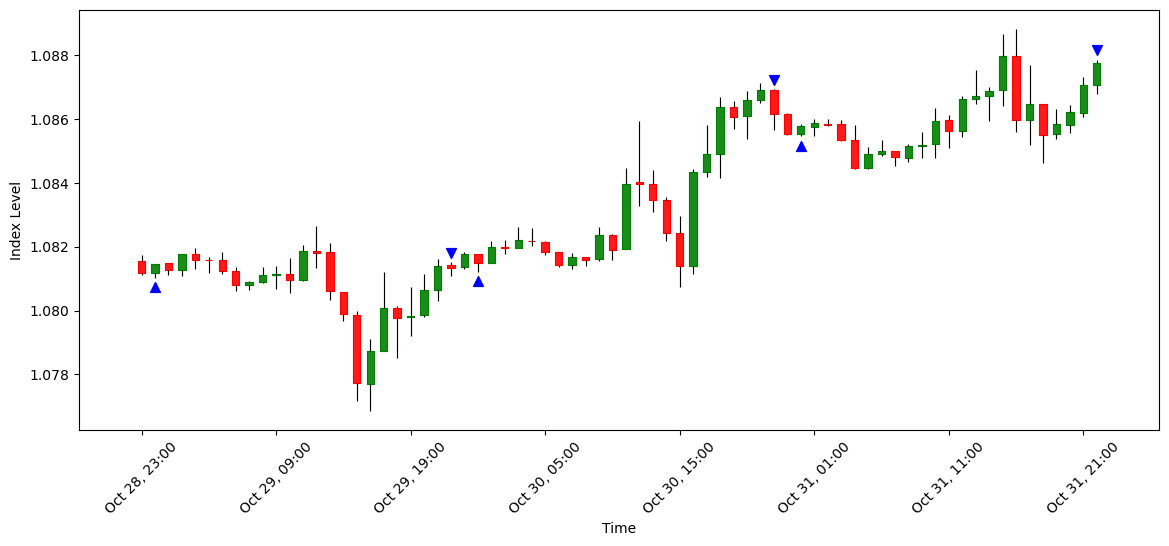

In [42]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


threshold = 0
threshold = 0.2

test['ind_up'] = ((test['pred_y_up'] - test['pred_y_down']) > threshold).astype(float)
test.loc[test['ind_up'] != 1, 'ind_up'] = float("NaN")
test.loc[test['ind_up'] == 1, 'ind_up'] = test['low'] - 0.0003

test['ind_down'] = ((test['pred_y_down'] - test['pred_y_up']) > threshold).astype(float)
test.loc[test['ind_down'] != 1, 'ind_down'] = float("NaN")
test.loc[test['ind_down'] == 1, 'ind_down'] = test['high'] + 0.0003


res = test[['y_true', 'ind_up', 'y_true_down', 'ind_down']]

res.loc[res['ind_up'] > 0, 'ind_pred'] = 1
res.loc[res['ind_down'] > 0, 'ind_pred'] = 0

res = res[(res['ind_pred'] == 1) | (res['ind_pred'] == 0)]

print(f'THR:\t {threshold}')
pdf.metrics.metrics_class(res.loc[:,'y_true'], res.loc[:,'ind_pred'])


plot_window = 24*3

data = test.tail(plot_window)
data.index = pd.to_datetime(data['date'] + " " + data['time'])

get_graph(data)

In [192]:
test

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,predict_cls_R1L1,predict_R2L1,predict_cls_R2L1,predict_C1L2_cls,pred_y_up,predict_C2L2_cls,pred_y_down,ind_up,ind_down,ind_pred
0,2022.11.18,Friday,04:00,Night,1.03676,1.03781,1.03649,1.03679,4107,0.00102,...,0,1.036045,0,0,0.499240,0,0.495241,NaN,NaN,NaN
1,2022.11.18,Friday,05:00,Night,1.03677,1.03910,1.03674,1.03828,3398,0.00082,...,0,1.039435,1,1,0.513066,0,0.478644,1.03644,NaN,1.0
2,2022.11.18,Friday,06:00,Morning,1.03827,1.03831,1.03613,1.03650,2449,0.00181,...,0,1.037387,1,1,0.504557,0,0.486176,1.03583,NaN,1.0
3,2022.11.18,Friday,07:00,Morning,1.03650,1.03720,1.03620,1.03718,2991,0.00002,...,1,1.037105,0,0,0.484809,1,0.510518,NaN,1.03750,0.0
4,2022.11.18,Friday,08:00,Morning,1.03720,1.03768,1.03599,1.03756,3903,0.00012,...,1,1.037062,0,0,0.482540,1,0.511420,NaN,1.03798,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12132,2024.10.31,Thursday,18:00,Evening,1.08647,1.08648,1.08462,1.08550,8408,0.00098,...,0,1.084996,0,0,0.482752,1,0.510535,NaN,1.08678,0.0
12133,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,1,1.085293,0,0,0.492422,1,0.500098,NaN,NaN,NaN
12134,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,1,1.085781,0,0,0.491443,1,0.502458,NaN,1.08674,0.0
12135,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,0,1.086663,0,1,0.502040,0,0.486305,1.08576,NaN,1.0


In [603]:
import shap
shap.initjs()

In [613]:
explainer = shap.TreeExplainer(model_C1L2)
shap_values = explainer.shap_values(test[XL2])

In [615]:
pd.DataFrame(shap_values, columns=XL2)

,time,weekday,daypart,open_change,close_change,high_change,low_change,open_ratio,close_ratio,high_low_range,...,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24,momentum,volatility,predict_R1L1,predict_R2L1,predict_cls_R1L1,predict_cls_R2L1
0,-0.000015,0.0,0.000359,0.0,0.0,0.0,0.0,0.0,0.0,-0.000674,...,0.0,0.0,0.0,0.0,0.0,-0.000665,0.000485,-0.000208,0.039980,0.017397
1,-0.000026,0.0,0.000359,0.0,0.0,0.0,0.0,0.0,0.0,-0.001715,...,0.0,0.0,0.0,0.0,0.0,-0.000650,0.000485,-0.000202,0.036955,0.014294
2,-0.000386,0.0,0.000484,0.0,0.0,0.0,0.0,0.0,0.0,0.002452,...,0.0,0.0,0.0,0.0,0.0,-0.000663,0.000772,-0.000209,0.048106,0.019443
3,-0.000386,0.0,-0.000247,0.0,0.0,0.0,0.0,0.0,0.0,0.002198,...,0.0,0.0,0.0,0.0,0.0,-0.000718,0.000772,-0.000095,0.044797,0.020170
4,-0.000717,0.0,-0.000392,0.0,0.0,0.0,0.0,0.0,0.0,-0.003444,...,0.0,0.0,0.0,0.0,0.0,-0.000748,0.000560,-0.000083,0.035637,0.014209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12128,-0.000746,0.0,-0.001151,0.0,0.0,0.0,0.0,0.0,0.0,0.005577,...,0.0,0.0,0.0,0.0,0.0,0.000328,-0.001469,-0.000163,-0.031575,-0.012876
12129,-0.000727,0.0,-0.001151,0.0,0.0,0.0,0.0,0.0,0.0,0.005772,...,0.0,0.0,0.0,0.0,0.0,0.000291,-0.001469,-0.000163,-0.032188,-0.012945
12130,-0.000329,0.0,-0.000949,0.0,0.0,0.0,0.0,0.0,0.0,-0.005599,...,0.0,0.0,0.0,0.0,0.0,0.000506,-0.001250,-0.000307,-0.042424,-0.018076
12131,-0.000329,0.0,-0.000575,0.0,0.0,0.0,0.0,0.0,0.0,-0.013002,...,0.0,0.0,0.0,0.0,0.0,0.000633,-0.001201,-0.000599,-0.056377,-0.022293


In [617]:
shap.force_plot(explainer.expected_value, shap_values[0,:], test[XL2].iloc[0,:])

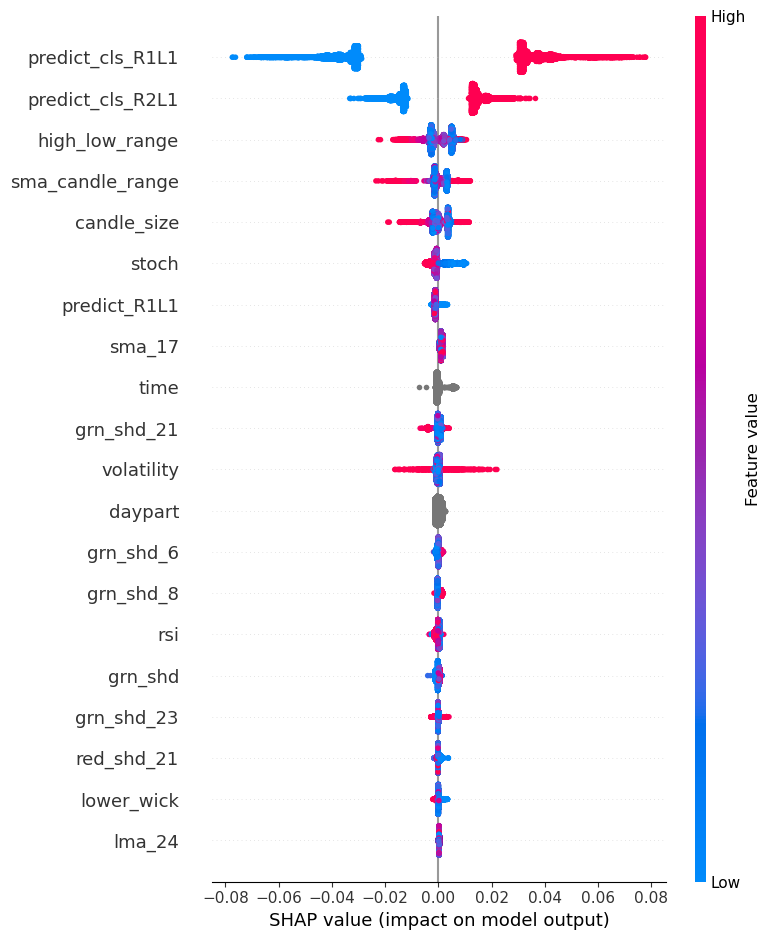

In [619]:
shap.summary_plot(shap_values, test[XL2])